# DN trajectory from cell neighbourhoods 

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
import palantir
import dandelion as ddl

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
import milopy
import milopy.core as milo
import milopy.plot as milopl

In [3]:
sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
sb.set_palette('colorblind')

In [4]:
ct_order = ['DN(early)_T','DN(P)_T', 'DN(Q)_T', 'DP(P)_T', 'DP(Q)_T',
             'ILC2', 'ILC3','CYCLING_ILC','NK', 'CYCLING_NK']
ct_color_map = dict(zip(ct_order, np.array(sb.color_palette('colorblind'))[range(len(ct_order))]))

In [5]:
# set working directory
%cd /lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/

/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript


In [6]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

In [7]:
#### need to add this line to restore plotting function of scanpy
%matplotlib inline

In [8]:
plot = ['pseudotime','prob_NK','prob_T']

In [9]:
# import utils (in github folder utils)
import sys
sys.path.append('/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/utils')
from _chenqu_utils import *

# Load data

In [10]:
# object loaded with abTCR, gdTCR, BCR data in 02_panfetal_load_VDJ
adata_source = sc.read('write/PAN.A01.v01.entire_data_normalised_log.20210429.LYMPHOID.embedding_dandelion_110123.h5ad')

Only considering the two last: ['.embedding_dandelion_110123', '.h5ad'].
Only considering the two last: ['.embedding_dandelion_110123', '.h5ad'].


In [11]:
adata_count = sc.read('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_raw_count.20210429.LYMPHOID.h5ad')

Only considering the two last: ['.LYMPHOID', '.h5ad'].
Only considering the two last: ['.LYMPHOID', '.h5ad'].


/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### abTCR - filter samples that have been sequenced

In [12]:
meta_ab = pd.read_csv('metadata/abTCR_metadata_cleaned_24032022.csv')

In [13]:
adata = adata_source[adata_source.obs['file'].isin(meta_ab['GEX_id'])].copy() # only leave samples that have been abTCR-sequenced

### subset cells to DN onwards, and cells with TRBJ

In [14]:
# utility function to setup the data to change all the entries to the first vdj call and remove entries with ',' i.e. inconfident calling
bdata = ddl.tl.setup_vdj_pseudobulk(adata, 
                                    subsetby='anno_lvl_2_final_clean', 
                                    groups = ct_order, 
                                    productive_vdj=False, 
                                    productive_vj=False,
                                    check_vdj_mapping=['j_call'],
                                    check_vj_mapping=None,
                                    mode='abT'
                                   )
bdata

AnnData object with n_obs × n_vars = 30882 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'bbk', 'scvi_clusters', 'anno_lvl_2_LYMPHOID', 'anno_lvl_2_MYELOID', 'anno_lvl_2_MEM_PROGENITORS', 'leiden_150', 'anno_lvl_2_final_clean', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'v_call_genotyped_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_genotyped_abT_VJ', 'j_call_

### Select neighbourhoods 

In [15]:
sc.pp.neighbors(bdata, use_rep = "X_scvi", n_neighbors = 50)

In [16]:
sc.tl.umap(bdata, random_state = 1712)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


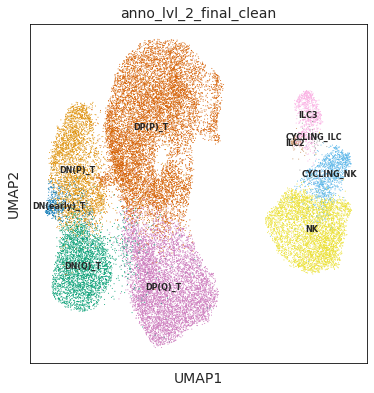

In [17]:
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(bdata,color=['anno_lvl_2_final_clean'],legend_loc='on data',legend_fontsize=8,palette = ct_color_map)

In [18]:
milo.make_nhoods(bdata)

In [19]:
# build neighbourhood adata in bdata.uns['nhood_adata']
milopy.core.count_nhoods(bdata, sample_col='file') # this step is needed to build bdata.uns['nhood_adata'] and sample_col can be anything
# this step is needed for plotting below
milopy.utils.build_nhood_graph(bdata)

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [20]:
# assign neighbourhood celltype by majority voting
# results are in bdata.uns['nhood_adata'].obs['nhood_annotation'] & bdata.uns['nhood_adata'].obs['nhood_annotation_frac'] 
milopy.utils.annotate_nhoods(bdata, anno_col='anno_lvl_2_final_clean')

### Plotting neighbourhood graph on same UMAP (**optional - not needed for downstream analysis)

In [21]:
# remove edges if the min no of shared cells btw nhoods are less than min_overlap, this is to 
min_overlap = 30
nhood_conn = bdata.uns['nhood_adata'].obsp['nhood_connectivities'].todense()
nhood_conn[nhood_conn < min_overlap] = 0
bdata.uns['nhood_adata'].obsp['nhood_connectivities'] = sp.sparse.csr_matrix(nhood_conn)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


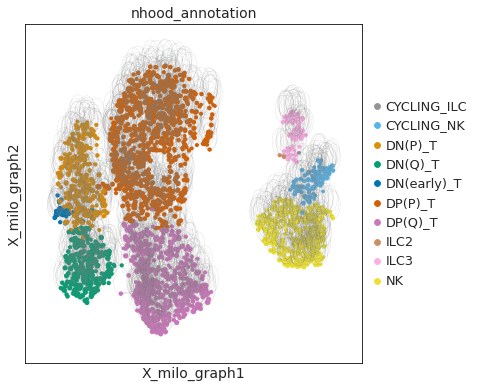

In [22]:
# plot nhood on UMAP, but legend does not include line thickness and node size
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.embedding(bdata.uns['nhood_adata'], basis='X_milo_graph', sizes=list(bdata.uns['nhood_adata'].obs['Nhood_size']),
                color='nhood_annotation',palette=ct_color_map,edges=True, 
                neighbors_key='nhood')

In [23]:
# plot the above in R to include the full legend
# save the following object and follow nhood_plot_dn.R
pd.DataFrame(nhood_conn).to_csv('csv/nhood_conn_dn.csv')
pd.DataFrame(bdata.uns['nhood_adata'].obsm['X_milo_graph']).to_csv('csv/layout_dn.csv')
bdata.uns['nhood_adata'].obs.to_csv('csv/nhood_obs_dn.csv')

Now neighbourhood adata is stored in bdata.uns['nhood_adata']

# Create neighbourhood VDJ feature space

In [24]:
# function for making neighbourhood vdj feature space
# cols are the columns of VDJ to be used here
nhood_adata = ddl.tl.vdj_pseudobulk(bdata, pbs = bdata.obsm['nhoods'], obs_to_take = 'anno_lvl_2_final_clean', 
                                    extract_cols=['j_call_abT_VDJ_main'])

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [25]:
nhood_adata

AnnData object with n_obs × n_vars = 2405 × 14
    obs: 'anno_lvl_2_final_clean', 'anno_lvl_2_final_clean_fraction', 'cell_count'
    obsm: 'pbs'

     nhood_adata is the new neighbourhood VDJ feature space, whereby each observation is a cell neighbourhood
     VDJ usage frequency stored in nhood_adata.X
     VDJ genes stored in nhood_adata.var
     neighbourhood metadata stored in nhood_adata.obs
     can visualise the data using PCA or UMAP (see below)

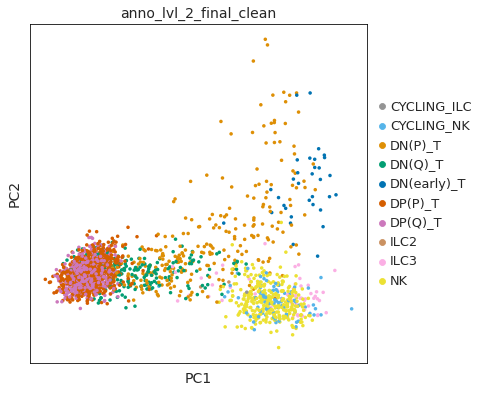

In [26]:
sc.pp.pca(nhood_adata, random_state = 1712)
sc.pl.pca(nhood_adata, color=['anno_lvl_2_final_clean'],palette=ct_color_map,save = 'TCR_nhood_PCA_dn.pdf')

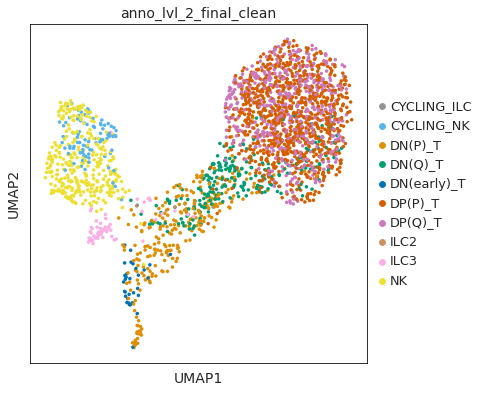

In [27]:
sc.pp.neighbors(nhood_adata, random_state = 1712)
sc.tl.umap(nhood_adata, random_state = 1712)
sc.pl.umap(nhood_adata, color=['anno_lvl_2_final_clean'],palette=ct_color_map,save = 'TCR_nhood_umap_dn.pdf')

In [28]:
### optional (only for plotting)
# save first 2 PCs for plotting in 01_nhood_plot.R
pd.DataFrame(nhood_adata.obsm['X_pca'][:,[0,1]]).to_csv('csv/layout_vdj_pca_dn.csv')
pd.DataFrame(nhood_adata.obsm['X_umap'][:,[0,1]]).to_csv('csv/layout_vdj_umap_dn.csv')

# Use palantir to do pseudotime

In [29]:
# Run diffusion maps
pca_projections = pd.DataFrame(nhood_adata.obsm['X_pca'], index=nhood_adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)

Determing nearest neighbor graph...


In [30]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

Find rootcell & terminal states
rootcell - neighbourhood with highest CD34 expression

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


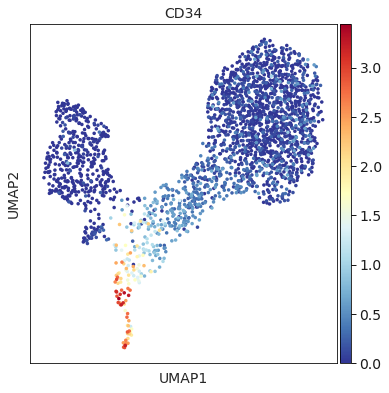

In [31]:
# make a new neighbourhood object with the same umap embedding as nhood_adata, but .X is the pseudobulked gene expression

# step1: subset the object with raw count to the same cells as bdata
bdata_raw = adata_count[bdata.obs_names].copy()

# step2: pseudobulk gene expression by neighbourhood
nhood_adata_gex = ddl.tl.pseudobulk_gex(adata_raw = bdata_raw, pbs = bdata.obsm['nhoods'])
# perform normalization and log transformation
sc.pp.normalize_per_cell(nhood_adata_gex,counts_per_cell_after=10e4)
sc.pp.log1p(nhood_adata_gex)

# step3: make new object nhood_adata_plot
nhood_adata_plot = sc.AnnData(nhood_adata_gex.X, obs=nhood_adata.obs, var=nhood_adata_gex.var, obsm=nhood_adata.obsm)

# step4: plot CD34 expression
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(nhood_adata_plot, color=['CD34'])

# step5: choose the neighbourhood with highest CD34 expression as the rootcell
rootcell = np.argmax(nhood_adata_plot[:,'CD34'].X)

In [32]:
nhood_adata.obs['rootcell'] = 0
nhood_adata.obs.loc[rootcell.astype('str'),'rootcell'] = 1

In [33]:
terminal_states = pd.Series(['NK', 'T'], 
                           index=nhood_adata.obs_names[[np.argmin(nhood_adata.obsm['X_umap'][:,0]),np.argmax(nhood_adata.obsm['X_umap'][:,0])]])

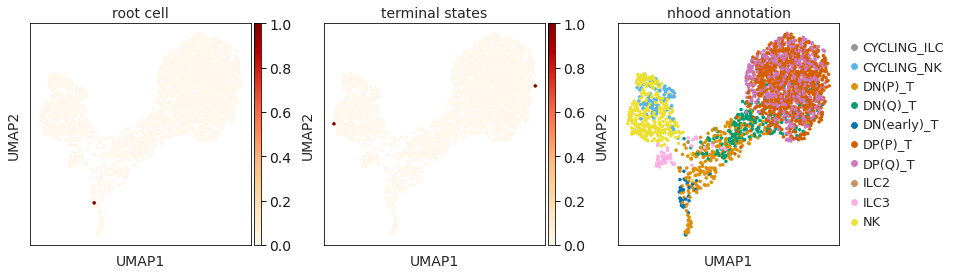

In [34]:
# plot rootcell and terminal states
nhood_adata.obs['terminal_states'] = 0
nhood_adata.obs.loc[terminal_states.index, 'terminal_states'] = 1
plt.rcParams["figure.figsize"] = [4,4]
sc.pl.umap(nhood_adata,color=['rootcell','terminal_states','anno_lvl_2_final_clean'],
           title=['root cell', 'terminal states','nhood annotation'],color_map='OrRd',save='dn_rootcell_term.pdf')

Compute pseudotime & fate probabilities 

In [35]:
pr_res = palantir.core.run_palantir(ms_data,  nhood_adata.obs_names[rootcell], num_waypoints=500, 
                                    terminal_states = terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0024139046669006347 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.1093044360478719 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/palantir/core.py:447: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/palantir/core.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [36]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

In [37]:
# function to add pseudotime information onto nhood_adata
# pseudotime stored in .obs['pseudotime'], branch probabilities in .obs['prob_'+terminal_state_name]
ddl.tl.pseudotime_transfer(adata = nhood_adata, pr_res = pr_res, suffix = '_nhood_vdj')

AnnData object with n_obs × n_vars = 2405 × 14
    obs: 'anno_lvl_2_final_clean', 'anno_lvl_2_final_clean_fraction', 'cell_count', 'rootcell', 'terminal_states', 'pseudotime_nhood_vdj', 'prob_T_nhood_vdj', 'prob_NK_nhood_vdj'
    uns: 'pca', 'anno_lvl_2_final_clean_colors', 'neighbors', 'umap'
    obsm: 'pbs', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

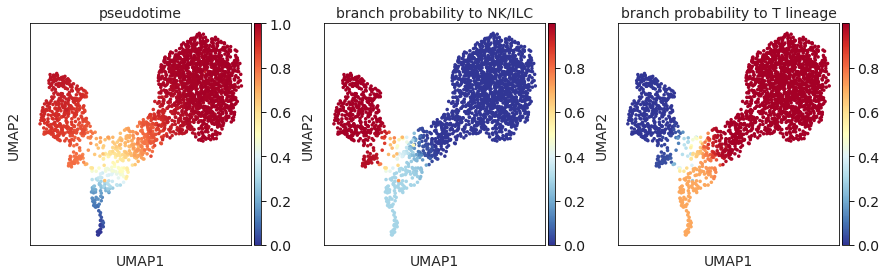

In [38]:
sc.pl.umap(nhood_adata,color=[term + '_nhood_vdj' for term in plot],title=['pseudotime','branch probability to NK/ILC','branch probability to T lineage'],
          save='dn_tcr_pseudotime.pdf')

In [39]:
#nhood_adata.write('write/DN_nhood_adata_pseudotime.h5ad')
nhood_adata.write('write/DN_nhood_adata_pseudotime_110123.h5ad')
# somehow this is needed to write bdata
for col in bdata.obs.columns:
    bdata.obs[col] = bdata.obs[col].astype('str')
bdata.uns['nhood_adata'].uns['annotation_labels'] = np.nan
#bdata.write('write/DN_cell_adata.h5ad')
bdata.write('write/DN_cell_adata_110123.h5ad')

In [40]:
nhood_adata = sc.read('write/DN_nhood_adata_pseudotime_110123.h5ad')
bdata = sc.read('write/DN_cell_adata_110123.h5ad')

# project pseudotime and branch probabilities back to cells

In [41]:
# project pseudotime and branch probabilities back to cell. results stored in cdata.obs
cdata = ddl.tl.project_pseudotime_to_cell(adata = bdata, 
                               pb_adata = nhood_adata, 
                               term_states=['NK','T'], 
                               suffix = '_nhood_vdj')
# cdata is bdata removing cells that don't belong to any neighbourhood 

number of cells removed due to not belonging to any neighbourhood 131


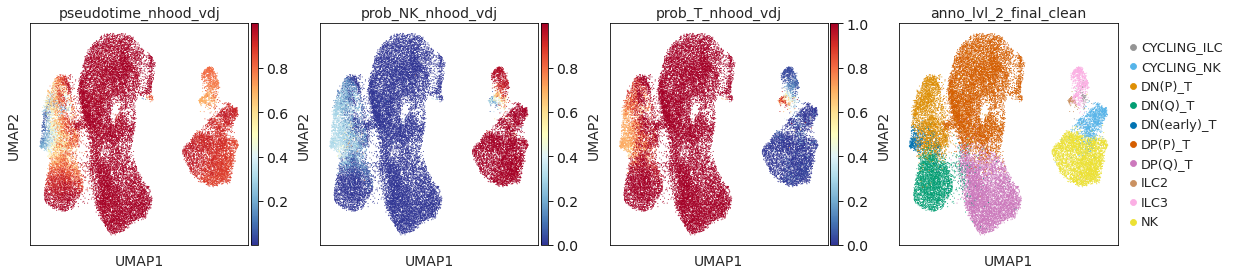

In [42]:
sc.pl.umap(cdata,color=[term + '_nhood_vdj' for term in plot]+['anno_lvl_2_final_clean'], save = 'dn_cell_pseudotime.pdf')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


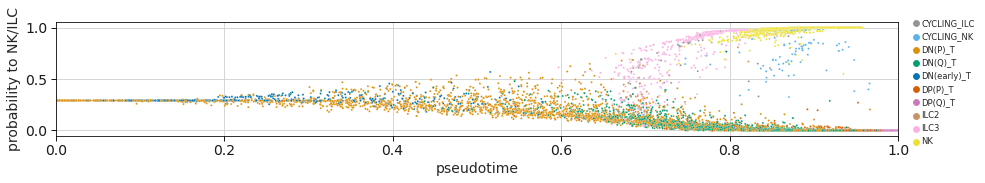

In [43]:
fig, ax = plt.subplots(figsize=(15,2))
plt.subplots_adjust(hspace=0.6)
ax= sb.scatterplot(data=cdata.obs, x ='pseudotime_nhood_vdj',y='prob_NK_nhood_vdj',s=4,hue='anno_lvl_2_final_clean',palette = ct_color_map)
ax.set(xlim=(0, 1))
ax.set_ylabel('probability to NK/ILC', fontsize=14)    
ax.set_xlabel('pseudotime')
h,l = ax.get_legend_handles_labels()
l1 = ax.legend(h[:10],l[:10], loc='upper right',bbox_to_anchor=(1.1, 1.1),frameon=False, fontsize='small')

plt.savefig(fig_path+'dn_pseudotime.pdf',bbox_inches='tight')

In [44]:
#cdata.write('write/DN_cell_adata_pseudotime.h5ad')
cdata.write('write/DN_cell_adata_pseudotime_110123.h5ad')

In [45]:
cdata = sc.read('write/DN_cell_adata_pseudotime_110123.h5ad')

# Use chatterjee correlation to look at genes that change with pseudotime in DN(P), DN(Q)

In [225]:
cdata_DN = cdata[cdata.obs['anno_lvl_2_final_clean'].isin(['DN(early)_T','DN(P)_T','DN(Q)_T'])]

Plot known TFs in murine DN development

In [226]:
markers = ['HES1','TCF7','GATA3','BCL11B','LEF1','ETS1','SPI1','LYL1','HHEX','BCL11A','HOXA9','MEF2C','TCF3','IKZF1','RUNX1','TCF12','GFI1']

In [227]:
gene_summary = bin_expression(adata = cdata_DN, bin_no = 100, genes = markers, pseudotime_col='pseudotime_nhood_vdj')

<ipython-input-228-b9874d66bf87>:3: UserWarning: FixedFormatter should only be used together with FixedLocator


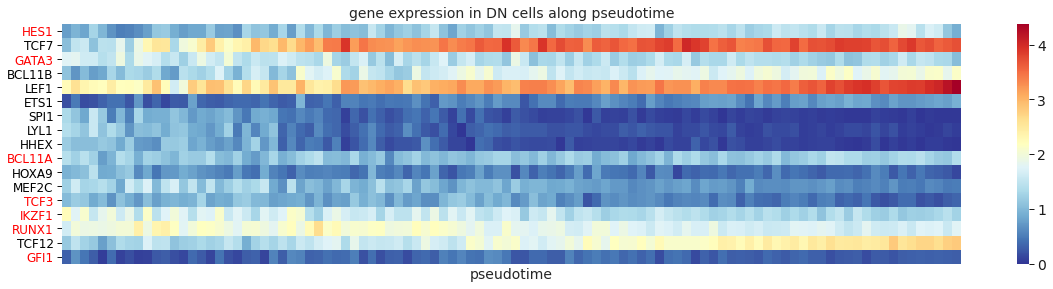

In [228]:
plot = gene_summary.copy()
fig, ax = plt.subplots(figsize=(20,plot.shape[0]/4))
ax.set_yticklabels(plot.index,size=12)
ax.tick_params(left=True, bottom=False)
ax = sb.heatmap(plot,cmap = 'RdYlBu_r', xticklabels=False)
ax.set_xlabel('pseudotime')
ax.set_title('gene expression in DN cells along pseudotime')

# change y tick labels 
marker_diff = ['HES1','GATA3','BCL11A','TCF3','IKZF1','RUNX1','GFI1']
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    if tick_label.get_text() in marker_diff:
        tick_label.set_color("red")
    else:
        tick_label.set_color("black")
plt.savefig(fig_path+'dn_pseudotime_tf_selected.pdf',bbox_inches='tight')

Chatterjee correlation of gene expression with pseudotime

In [229]:
# filter out genes that are expressed in < 50 cells
sc.pp.filter_genes(cdata_DN, min_cells=50)

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


In [230]:
def chatterjee_corr(adata, genes, pseudotime_col, tie_breaking='theoretical'):
    from scipy.stats import rankdata
    
    # get gene expression
    x = np.array(adata[:,genes].X.todense())
    # get pseudotime
    y = list(adata.obs[pseudotime_col])
    
    # compute chatterjee correlation
    # ref: Sourav Chatterjee (2021) A New Coefficient of Correlation, Journal of the American Statistical Association, 116:536, 2009-2022, DOI: 10.1080/01621459.2020.1758115
    
    if tie_breaking == 'theoretical':
        n_cell, n_gene = x.shape
        stat = np.zeros(n_gene)
        x_sorted = x[np.argsort(y), :]
        r = rankdata(x_sorted, method='max', axis=0)
        l = n_cell + 1 - rankdata(x_sorted, method='min', axis=0)
        stat = 1 - n_cell * np.sum(np.abs(np.diff(r, axis=0)), axis=0) / 2 / np.sum(l * (n_cell - l), axis=0)
        u = np.sort(r, axis=0) / n_cell
        v = np.cumsum(u, axis=0) / n_cell
        ind = np.arange(1, n_cell+1).reshape((u.shape[0], 1)) / n_cell
        a = np.sum((2 * (1 - ind) + 1 / n_cell) * (u ** 2), axis=0) / n_cell
        b = np.sum((v + (1 - ind) * u) ** 2, axis=0) / n_cell
        c = np.sum((2 * (1 - ind) + 1 / n_cell) * u, axis=0) / n_cell
        d = np.sum(l / n_cell * (1 - l / n_cell), axis=0) / n_cell
        tau2 = (a - 2 * b + c ** 2) / (d ** 2)
        '''
        
        for j in range(n_gene):
            print(j, '/', n_gene, end='\r', flush=True)
            x_j = x_sorted[:, j]
            mx = np.reshape(np.repeat(x_j, n_cell) >= np.tile(x_j, n_cell), (n_cell, n_cell))
            r = np.sum(mx, axis=1)
            l = np.sum(mx, axis=0)
            stat[j] = 1 - n_cell * np.sum(np.abs(np.diff(r))) / 2 / np.sum(l * (n_cell - l))
        '''
    elif tie_breaking == 'random':
        
        # add small perturbation for random tie breaking
        np.random.seed(0) # set random seed for consistent results
        x = x + np.random.randn(x.shape[0], x.shape[1]) * 1e-15  
        stat = 1 - np.sum(np.abs(np.diff(rankdata(x[np.argsort(y), :], axis=0), axis=0)), axis=0) * 3 / (x.shape[0] ** 2 - 1)
        stat = np.array(stat).flatten()
        tau2 = 2 / 5
    else:
        raise Exception("tie_breaking should be 'theoretical' or 'random'.")
    
    pval = 1 - sp.stats.norm.cdf(stat, loc=0, scale=np.sqrt(tau2/x.shape[0]))
    
    # put results into dataframe cor_res
    cor_res = pd.DataFrame({'cor_stat': stat, 'pval': pval})
    cor_res.index = genes
    
    # compute adjusted pval using BH method
    stats = importr('stats') 
    cor_res.loc[:,'adj_pval']=stats.p_adjust(FloatVector(cor_res.loc[:,'pval']), method = 'BH')

    # sort genes based on adjusted pval
    cor_res= cor_res.sort_values(by='adj_pval')
    
    return cor_res


In [231]:
cor_res = chatterjee_corr(adata = cdata_DN, genes=cdata_DN.var_names, pseudotime_col='pseudotime_nhood_vdj')

In [232]:
# cor_res_sig keeps the ones with adjusted pval < 0.05
cor_res_sig = cor_res[cor_res['adj_pval']<0.05]
cor_res_sig.to_csv('csv/dn_sig.csv')

In [233]:
# sort genes by cor_stat
cor_res_sig= cor_res_sig.sort_values(by='cor_stat',ascending=False)
# choose genes with cor_stat > 0.1 
gene_select = cor_res_sig.loc[cor_res_sig['cor_stat']>0.1,:]
#gene_select = cor_res_sig

In [234]:
gene_summary = bin_expression(adata = cdata_DN, bin_no = 100, genes = gene_select.index, pseudotime_col='pseudotime_nhood_vdj')

In [235]:
# order genes by peak time
df_order = [0]*gene_summary.shape[0]
for i in range(gene_summary.shape[0]):
    df_order[i] = np.argmax(gene_summary.iloc[i,:])
df_sorted = gene_summary.iloc[np.argsort(df_order),:]

look at TFs

In [236]:
TF = pd.read_csv('/home/jovyan/gene_list/human_TF_list.csv', header=1)
TF_list = list(TF['Name'][TF['Unnamed: 3']=='Yes'])
df_tf = df_sorted.loc[df_sorted.index.isin(TF_list),:]
#df_tf.to_csv('csv/dn_sig_tf.csv')

<ipython-input-237-d04544dfeddc>:3: UserWarning: FixedFormatter should only be used together with FixedLocator


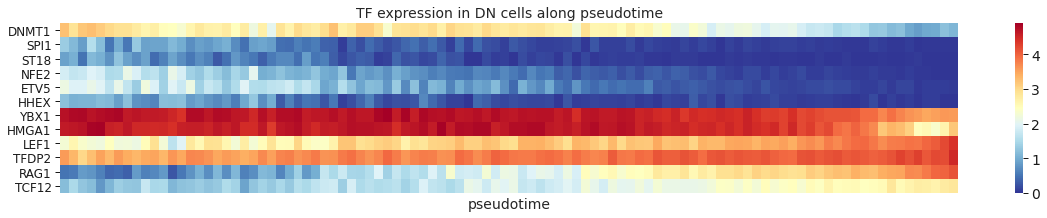

In [237]:
plot = df_tf.copy()
fig, ax = plt.subplots(figsize=(20,plot.shape[0]/4))
ax.set_yticklabels(plot.index,size=12)
ax.tick_params(left=True, bottom=False)
ax = sb.heatmap(plot,cmap = 'RdYlBu_r', xticklabels=False)
ax.set_xlabel('pseudotime')
ax.set_title('TF expression in DN cells along pseudotime')

plt.savefig(fig_path+'dn_pseudotime_tf.pdf',bbox_inches='tight')

look at surface genes

In [238]:
surface_gene = pd.read_csv('/home/jovyan/gene_list/surface_gene.txt', header=None)
surface_gene = list(surface_gene[0])
df_surface = df_sorted.loc[df_sorted.index.isin(surface_gene),:]

<ipython-input-239-6393d65dd89c>:3: UserWarning: FixedFormatter should only be used together with FixedLocator


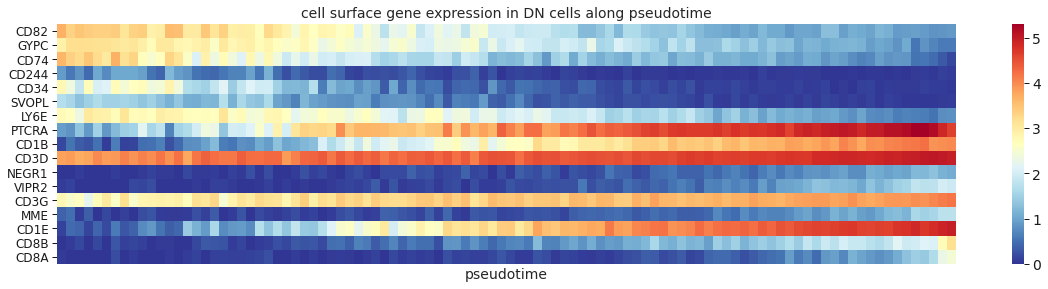

In [239]:
plot = df_surface.copy()
fig, ax = plt.subplots(figsize=(20,plot.shape[0]/4))
ax.set_yticklabels(plot.index,size=12)
ax.tick_params(left=True, bottom=False)
ax = sb.heatmap(plot,cmap = 'RdYlBu_r', xticklabels=False)
ax.set_xlabel('pseudotime')
ax.set_title('cell surface gene expression in DN cells along pseudotime')

plt.savefig(fig_path+'dn_pseudotime_surface.pdf',bbox_inches='tight')